In [2]:
import rdkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import mbuild as mb
import parmed
import torch
from torch import nn
import torch_geometric as tg
from torch_geometric.loader import DataLoader
import torch.utils.data
import shutil
import sys
import rdkit 
sys.path.insert(1, '~/egnn_cof/models/egnn_clean')
sys.path.insert(1, '~/egnn_cof')
# from easydict import EasyDict as edict
import torch
from torch import nn, optim
# My imports
from loader import *
from megnn import *
from utils import *

In [3]:
dat = Cloud_Point_Dataset(root='.')

In [5]:
dat.dataframe

AttributeError: 'Cloud_Point_Dataset' object has no attribute 'dataframe'

In [4]:
def compute_mean_mad(series):
    values = torch.Tensor(series)
    mean = torch.mean(values)
    ma = torch.abs(values - mean)
    mad = torch.mean(ma)
    return mean, mad

# clear the processed dataset
shutil.rmtree('./processed')

n_epochs  = 2
device = torch.device("cpu")
dtype = torch.float32
dat = Cloud_Point_Dataset(root='.')

batch_size = 32

dat.shuffle()
train_dataset = dat[:4000]
test_dataset = dat[4000:5000]
valid_dataset = dat[5000:]
train_loader = DataLoader(train_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t','positions_s', 'positions_t'], shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t','positions_s', 'positions_t'], shuffle=False)

prop_mean, prop_mad = compute_mean_mad(dat.dataframe['CP (C)'])

# model = MEGNN(n_graphs=2, in_node_nf=len(dat.elements), in_edge_nf=0, hidden_nf=128, device=device, n_layers=7, coords_weight=1.0,
#              attention=False, node_attr=1)
model = PairEGNN(in_node_nf=len(dat.elements), in_edge_nf=0, hidden_nf=128, device=device, n_layers=7, coords_weight=1.0,
             attention=False, node_attr=1)

optimizer = optim.Adam(model.parameters(), lr=.001)
loss_func = nn.MSELoss()


def train(epoch, loader, res, partition='train'):
    # lr_scheduler.step()
    # res = {'loss': 0, 'counter': 0, 'loss_arr':[]}
    epoch_loss = 0
    for i, data in enumerate(loader):
        if partition == 'train':
            model.train()
            optimizer.zero_grad()

        else:
            model.eval()

        dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
        dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
        batch_size_s, n_nodes_s, _ = dense_positions_s.size()
        batch_size_t, n_nodes_t, _ = dense_positions_t.size()
        atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
        atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)

        edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_s *= diag_mask
        edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
        edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_t *= diag_mask
        edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)

        atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
        atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)

        one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
        one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
        one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
        one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
        edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
        edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)

        label = data.y.to(device, dtype)
        # MEGNN
        # pred = model(h0=[one_hot_s, one_hot_t], all_edges=[edges_s, edges_t], all_edge_attr=None, node_masks=[atom_mask_s, atom_mask_t],
        #             edge_masks=[edge_mask_s, edge_mask_t], n_nodes=[n_nodes_s, n_nodes_t], x=[atom_positions_s, atom_positions_t])
        #PairEGNN
        pred = model(h0_s=one_hot_s, h0_t=one_hot_t, edges_s=edges_s, edges_t=edges_t, edge_attr=None, node_mask_s=atom_mask_s, 
                    edge_mask_s=edge_mask_s, n_nodes_s=n_nodes_s, node_mask_t=atom_mask_t, edge_mask_t=edge_mask_t, 
                    n_nodes_t=n_nodes_t, x_s=atom_positions_s, x_t=atom_positions_t)
        loss = loss_func(pred, label)
        
        if partition == 'train':
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            res['step'].append(batch_size*i+epoch*len(loader))

        prefix = ""
        if partition != 'train':
            prefix = ">> %s \t" % partition

        if i % 10 == 0 and i != 0:
            print(prefix + "Epoch %d \t Iteration %d \t loss %.4f" % (epoch, i, epoch_loss/res['step'][-1]))
    if partition == 'test':
        res['test epoch loss'].append(epoch_loss)
    elif partition == 'valid':
        res['valid epoch loss'].append(epoch_loss)
    else:
        res['loss'].append(epoch_loss)

    return

res = {'epochs': [], 'test epoch loss':[], 'valid epoch loss':[], 'loss': [],
'step':[], 'best_val': 1e10, 'best_test': 1e10, 'best_epoch': 0}

for epoch in range(0, n_epochs):
    res['epochs'].append(epoch)
    train(epoch, train_loader, res, partition='train')
    if epoch % 2 == 0:
        train(epoch, valid_loader, res, partition='valid')
        train(epoch, test_loader, res, partition='test')

        if res['valid epoch loss'][-1] < res['best_val']:
            res['best_val'] = res['valid epoch loss'][-1]
            res['best_test'] = res['test epoch loss'][-1]
            res['best_epoch'] = epoch
        print("Val loss: %.4f \t test loss: %.4f \t epoch %d" % (res['valid epoch loss'][-1], res['test epoch loss'][-1], epoch))
        print("Best: val loss: %.4f \t test loss: %.4f \t epoch %d" % (res['best_val'], res['best_test'], res['best_epoch']))

Processing...
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (3)
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (5)
[12:41:37] Molecule does not have explicit Hs. Consider calling AddHs()
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (0)
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (3)
[12:41:37] Molecule does not have explicit Hs. Consider calling AddHs()
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (0)
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (3)
[12:41:37] Molecule does not have explicit Hs. Consider calling AddHs()
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (0)
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (6)
[12:41:37] Molecule does not have explicit Hs. Consider calling AddHs()
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (0)
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (3)
[12:41:37] Molecule does not have explicit Hs. Consider calling AddHs()
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (0)
[12:41:37] UFFTYPER: Unrecognized atom type: *_ (3)
[1

Epoch 0 	 Iteration 10 	 loss 371.0417
Epoch 0 	 Iteration 20 	 loss 322.1385
Epoch 0 	 Iteration 30 	 loss 331.6545
Epoch 0 	 Iteration 40 	 loss 308.9701
Epoch 0 	 Iteration 50 	 loss 844.6160
Epoch 0 	 Iteration 60 	 loss 725.8174
Epoch 0 	 Iteration 70 	 loss 641.2310
Epoch 0 	 Iteration 80 	 loss 575.8489
Epoch 0 	 Iteration 90 	 loss 522.7098
Epoch 0 	 Iteration 100 	 loss 481.4812
Epoch 0 	 Iteration 110 	 loss 446.2387
Epoch 0 	 Iteration 120 	 loss 417.1975
>> test 	Epoch 0 	 Iteration 10 	 loss 0.0000
>> test 	Epoch 0 	 Iteration 20 	 loss 0.0000
>> test 	Epoch 0 	 Iteration 30 	 loss 0.0000
Val loss: 0.0000 	 test loss: 0.0000 	 epoch 0
Best: val loss: 0.0000 	 test loss: 0.0000 	 epoch 0
Epoch 1 	 Iteration 10 	 loss 91.5117
Epoch 1 	 Iteration 20 	 loss 101.1844
Epoch 1 	 Iteration 30 	 loss 101.8714
Epoch 1 	 Iteration 40 	 loss 102.0815
Epoch 1 	 Iteration 50 	 loss 102.6074
Epoch 1 	 Iteration 60 	 loss 103.4211
Epoch 1 	 Iteration 70 	 loss 102.3438
Epoch 1 	 Iteration

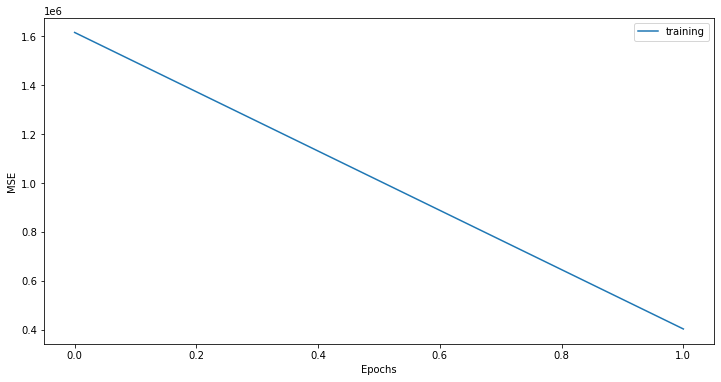

In [7]:
plt.figure(figsize=(12,6))
plt.plot( res['loss'],label='training')
# plt.plot(res['epochs'], res['test epoch loss'],label='testing')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()

In [4]:
# clear the processed dataset
shutil.rmtree('./processed')

n_epochs  = 2
device = torch.device("cpu")
dtype = torch.float32
dat = Cloud_Point_Dataset(root='.')

batch_size = 16

dat.shuffle()
train_dataset = dat[:4000]
test_dataset = dat[4000:5000]
valid_dataset = dat[5000:]
train_loader = DataLoader(train_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t','positions_s', 'positions_t'], shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t','positions_s', 'positions_t'], shuffle=False)

# model = MEGNN(n_graphs=2, in_node_nf=len(dat.elements), in_edge_nf=0, hidden_nf=128, device=device, n_layers=7, coords_weight=1.0,
#              attention=False, node_attr=1)
model = PairEGNN(in_node_nf=len(dat.elements), in_edge_nf=0, hidden_nf=128, device=device, n_layers=7, coords_weight=1.0,
             attention=False, node_attr=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

def train():
    model.train()
    epoch_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
        dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
        batch_size_s, n_nodes_s, _ = dense_positions_s.size()
        batch_size_t, n_nodes_t, _ = dense_positions_t.size()
        atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
        atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)
        edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
        diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_s *= diag_mask
        edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
        edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
        diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_t *= diag_mask
        edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)
        atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
        atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)
        one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
        one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
        one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
        one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
        edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
        edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)
        label = data.y.to(device, dtype)
        
        pred = model(h0_s=one_hot_s, h0_t=one_hot_t, edges_s=edges_s, edges_t=edges_t, edge_attr=None, node_mask_s=atom_mask_s, 
                    edge_mask_s=edge_mask_s, n_nodes_s=n_nodes_s, node_mask_t=atom_mask_t, edge_mask_t=edge_mask_t, 
                    n_nodes_t=n_nodes_t, x_s=atom_positions_s, x_t=atom_positions_t)
        loss = loss_func(pred, label)
        epoch_loss += loss
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return epoch_loss

def test(loader):
    model.eval()

    squared_error = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
        dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
        batch_size_s, n_nodes_s, _ = dense_positions_s.size()
        batch_size_t, n_nodes_t, _ = dense_positions_t.size()
        atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
        atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)
        edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
        diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_s *= diag_mask
        edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
        edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
        diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_t *= diag_mask
        edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)
        atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
        atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)
        one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
        one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
        one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
        one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
        edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
        edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)
        label = data.y.to(device, dtype)
        
        pred = model(h0_s=one_hot_s, h0_t=one_hot_t, edges_s=edges_s, edges_t=edges_t, edge_attr=None, node_mask_s=atom_mask_s, 
                    edge_mask_s=edge_mask_s, n_nodes_s=n_nodes_s, node_mask_t=atom_mask_t, edge_mask_t=edge_mask_t, 
                    n_nodes_t=n_nodes_t, x_s=atom_positions_s, x_t=atom_positions_t)
        res = data.y - pred
        
        squared_error.append(torch.pow(res, 2).sum())

    return sum(squared_error) / len(squared_error)

training_loss = []
testing_loss = []

for epoch in range(1, n_epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    training_loss.append(train_acc.detach().numpy())
    testing_loss.append(test_acc.detach().numpy())
    print(f'Epoch: {epoch:03d}, Train MSE: {train_acc:.4f}, Test MSE: {test_acc:.4f}')

Processing...
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (3)
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (5)
[13:56:55] Molecule does not have explicit Hs. Consider calling AddHs()
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (0)
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (3)
[13:56:55] Molecule does not have explicit Hs. Consider calling AddHs()
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (0)
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (3)
[13:56:55] Molecule does not have explicit Hs. Consider calling AddHs()
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (0)
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (6)
[13:56:55] Molecule does not have explicit Hs. Consider calling AddHs()
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (0)
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (3)
[13:56:55] Molecule does not have explicit Hs. Consider calling AddHs()
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (0)
[13:56:55] UFFTYPER: Unrecognized atom type: *_ (3)
[1